In [27]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random
from pprint import pprint

from SVD import Metrics, SVDPredictor, LogisticSVD
from RecData import RecData

In [8]:
# recs = pd.read_csv('data/recommendations.csv')
recs = pd.read_csv('data/pruned.csv')

# Remove old ratings
recs = recs.sort_values(by=['date'], ascending=False)
recs.drop_duplicates(subset= ['app_id', 'user_id'], inplace=True) 

USED_COLS = ['app_id', 'is_recommended', 'user_id']
recs = recs[USED_COLS]

item_data = pd.read_csv('data/games.csv')
titles = item_data[['app_id', 'title']]

print("Shape:", recs.shape)
recs.head()

Shape: (14585287, 3)


,app_id,is_recommended,user_id
2307118,1145360,True,2597309
1889941,1846380,True,4457610
7378728,1000360,True,1152924
7939199,262060,False,6207094
11381505,1657630,False,6372672


In [9]:
random.seed(42)
np.random.seed(42)

rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

del recs

print("Creating splits...")
train_data, test = rec_data.train_test_split(test_size=0.2)
print("First split done.")
train_data, val = train_data.train_test_split(test_size=0.2)
print("Done creating splits.")

Creating utility matrix...
Done utility matrix.
Creating splits...
First split done.
Done creating splits.


In [10]:
rec_data._num_users

6903784

In [11]:
# random.seed(42)
# np.random.seed(42)

# rec_data = RecData()
# rec_data.create_from_dataframe(recs)
# rec_data.set_titles(titles)

# del recs

# print("Creating splits...")
# train_data, val, test = rec_data.leave_k_out_split(k=1)
# print("Done creating splits.")

In [12]:
del item_data
del titles
del test

In [13]:
EPOCHS = 1

random.seed(42)
np.random.seed(42)

# Fit and predict with svd
svd_predictor = LogisticSVD(
    train_data.get_num_users(), train_data.get_num_items(), 2, k=20, 
    learning_rate=0.1, C=0.02)
svd_predictor.fit(train_data.get_matrix(), EPOCHS, validation_set=val, early_stop=False)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

Epoch 0/Training error: 0.6931398920632136/Validation error: 0.6931465008320493/Time: 295.84 seconds


KeyboardInterrupt: 

In [9]:
# Ensure file exists
model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(
    *(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 
file = open(model_dir, 'a')
file.close()

# Save model
print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump([svd_predictor, rec_data, train_data, val, test], file)
print("Done saving model.")

Saving model...
Done saving model.


In [31]:
svd_predictor.continue_fit(5, early_stop=False)

Epoch 0/Training error: 0.6904954833821758/Validation error: 0.6914856687577493/Time: 543.51 seconds
Epoch 1/Training error: 0.6885026461067679/Validation error: 0.6901818740968615/Time: 539.51 seconds
Epoch 2/Training error: 0.6851657872504451/Validation error: 0.6880008213906601/Time: 529.6 seconds
Epoch 3/Training error: 0.6798530671613469/Validation error: 0.6845534146729045/Time: 543.15 seconds
Epoch 4/Training error: 0.6720439887925987/Validation error: 0.6795510906047334/Time: 533.61 seconds


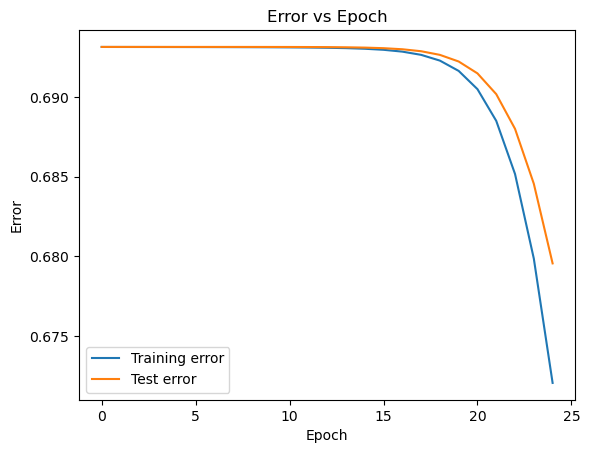

In [32]:
# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

In [55]:
j = 18
# Test top-n list for user j
top_n = svd_predictor.top_n(j, 20)
print("Predicted top n:")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

# User j true top n list
print("True top n:")
true_top = rec_data.top_n(j, 5000)
pprint([rec_data.index_to_title(index) for _, index in true_top])

Predicted top n:
[(0.5013777321948488, 'Robocraft'),
 (0.5007971318064313, 'Battlefield™ 2042'),
 (0.5005727995524938, 'Fishing Sim World®: Pro Tour'),
 (0.5005278574318396, 'Virtual Villagers Origins 2'),
 (0.5004813896600657, 'Back 4 Blood'),
 (0.5004617302129178, 'ATLAS'),
 (0.5004157638531984, 'Lords Mobile'),
 (0.5004115447254627, 'eFootball™ 2023'),
 (0.5004077618799592, 'Poppy Playtime'),
 (0.5003846832975539, 'Monster Energy Supercross - The Official Videogame 2'),
 (0.5003841407209008, 'Dark Deception: Monsters & Mortals'),
 (0.5003585320906222, 'Bum Simulator'),
 (0.5003571748817429, 'Hood: Outlaws & Legends'),
 (0.5003559796128065, 'STALCRAFT'),
 (0.500354134608845, "League of Angels-Heaven's Fury"),
 (0.5003530396946868, 'DwarfHeim'),
 (0.5003357468339915, 'Combat Arms: the Classic'),
 (0.5003273034421438, 'Z1 Battle Royale'),
 (0.5003147939375793, 'Chocolatier®: Decadence by Design™'),
 (0.5003094874001094, 'Hydroneer')]
True top n:
['Rust']


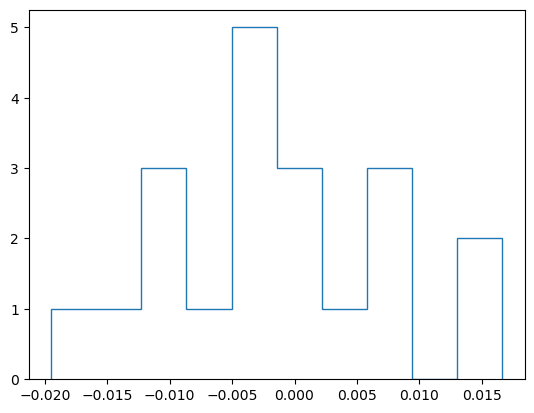

In [25]:
values, bins = np.histogram(svd_predictor._user_features[0, :])
plt.stairs(values, bins)
plt.show()

In [26]:
rec_data.search_title('mortal')

[('noel the mortal fate s1-7', 2161),
 ('mortal kombat x', 966),
 ('immortality', 856),
 ('mortal shell', 880),
 ('鬼谷八荒 tale of immortal', 1271),
 ('dark deception: monsters & mortals', 438),
 ('mortal online 2', 35),
 ('mortal kombat\xa011', 288)]

In [42]:
# prefs = [(606, 1), (1628, 1), (391, 0), (1330, 0), (500, 0), (709, 1), (840, 0), 
#          (58, 1), (456, 1), (153, 0), (158, 0), (1160, 0), (761, 0),
#                               (1771, 0), (544, 0), (312, 0), (277, 0)]
prefs = [(5, 1), (229, 1), (966, 0)]
pprint([(index, rec_data.index_to_title(index), pref) for index, pref in prefs])
prefs = rec_data.create_prefs(prefs)    

[(5, 'The Sims™ 4', 1), (229, 'The Sims™ 3', 1), (966, 'Mortal Kombat X', 0)]


In [43]:
svd_predictor._partial_batch_size = int(0)
start_time = time.time()
svd_predictor.partial_fit(prefs)
print("Completed partial fit in", time.time() - start_time, "seconds")

Epoch 0/Time: 0.0 seconds
Epoch 1/Time: 0.0 seconds
Epoch 2/Time: 0.0 seconds
Epoch 3/Time: 0.0 seconds
Epoch 4/Time: 0.0 seconds
Epoch 5/Time: 0.0 seconds
Epoch 6/Time: 0.0 seconds
Epoch 7/Time: 0.0 seconds
Epoch 8/Time: 0.0 seconds
Epoch 9/Time: 0.0 seconds
Epoch 10/Time: 0.0 seconds
Epoch 11/Time: 0.0 seconds
Epoch 12/Time: 0.0 seconds
Epoch 13/Time: 0.0 seconds
Epoch 14/Time: 0.0 seconds
Epoch 15/Time: 0.0 seconds
Epoch 16/Time: 0.0 seconds
Epoch 17/Time: 0.0 seconds
Epoch 18/Time: 0.0 seconds
Epoch 19/Time: 0.0 seconds
Completed partial fit in 0.7353808879852295 seconds


In [44]:
top_n = svd_predictor.top_n(svd_predictor._num_users - 1, 20)
print("Predicted top n")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

Predicted top n
[(0.5122110109698731, 'Resident Evil 7 Biohazard'),
 (0.5120208372111357, 'Resident Evil'),
 (0.5116862643439829, 'DOOM'),
 (0.5115722981578417, 'Call of Juarez: Gunslinger'),
 (0.5111017286889583, 'Half-Life 2'),
 (0.5108048975060161, 'BattleBlock Theater®'),
 (0.5107332294365285, 'Dead Space™ 2'),
 (0.5107150583686855, 'DUSK'),
 (0.5103489371871628, 'Portal'),
 (0.5102965786099124, 'BioShock Infinite'),
 (0.5100616615502553, 'The Wolf Among Us'),
 (0.5099860166257401, 'Metro 2033 Redux'),
 (0.5099265431804627, 'Yakuza Kiwami 2'),
 (0.5098722947108375, 'Yakuza Kiwami'),
 (0.5097445742007, 'Resident Evil 2'),
 (0.5097024115436736, 'Control Ultimate Edition'),
 (0.5096857221197233, 'Black Mesa'),
 (0.5096739690639523, 'Tomb Raider'),
 (0.5094042166804944, 'Resident Evil 5'),
 (0.5093816401235942, 'Sleeping Dogs: Definitive Edition')]
